# Setup

## Installation

## Library imports

The [RDKit cheminformatics library](https://rdkit.org/) provides a convenient, robust, and well tested interface for working with molecules. For our prototype we use the library's [canonicalization algorithm](https://doi.org/10.1021/acs.jcim.5b00543) and some convenience functions for manipulating and drawing molecules.

In [1]:
from rdkit.Chem import MolFromMolFile, DetectChemistryProblems
from rdkit import RDLogger                                                                                                                                                               
from pathlib import Path
from utils import *
RDLogger.DisableLog('rdApp.*')

MOLFILEPATH = "../test/testfiles"

# Canonicalization

First, we canonicalize the molecule. The canonicalization ensures that the molecules that are fed into our serialization are standardized. Otherwise, depending on the molecule's initial atom indices, there can be variations in the serialization result. The reason for this will hopefully get more clear in the remainder of this notebook.

In [2]:
m = MolFromMolFile(f"{MOLFILEPATH}/guanine/guanine.mol", removeHs=False)
m_canon = sort_molecule_by_canonical_indices(m)

Let's compare the atom order of the original and the canonicalized molecule.

original
╒═════════╤═════════════════╤═════════════╤═══════════════════════════════════════════════╕
│   index │   atomic number │   partition │ neighbors (index, atomic number, partition)   │
╞═════════╪═════════════════╪═════════════╪═══════════════════════════════════════════════╡
│       0 │               7 │           0 │ [(1, 6, 0), (5, 6, 0), (12, 1, 0)]            │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       1 │               6 │           0 │ [(0, 7, 0), (2, 7, 0), (10, 7, 0)]            │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       2 │               7 │           0 │ [(1, 6, 0), (3, 6, 0)]                        │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       3 │               6 │           0 │ [(2, 7, 0), (4, 6, 0), (6, 7, 0)]             │
├─────────┼─────────────────┼─────────────┼────────────────────────────

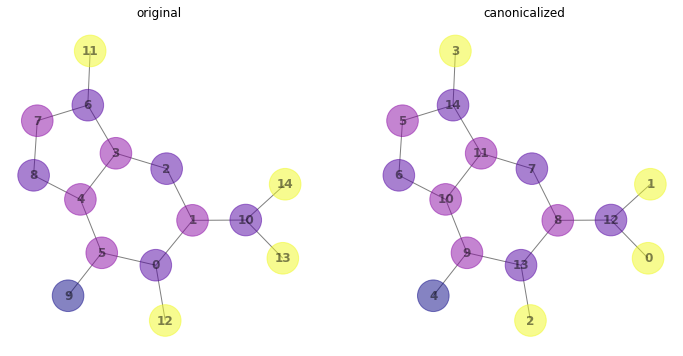

In [3]:
print_molecule(m, "original")
print_molecule(m_canon, "canonicalized")
draw_molecules([m, m_canon], ["original", "canonicalized"])

# Serialization

The serialization should result in a string representation of the molecule. The string representation should allow for the automatized reconstruction of the molecule's topology (i.e., the molecular graph). Additionally, ideally the representation should be intuitive enough for a human to be able to reconstruct the molecular graph.

Our string representation consists of the sum formula, followed by a sequence of tuples. Each tuple represents the indices of two connected atoms (i.e., `(index X, index Y)`). For example, the string representation of ethanol is `C2H6O:(0,6)(1,6)(2,6)(3,7)(4,7)(5,8)(6,7)(7,8)`.
In order to be able to reconstruct the molecule based on this representation, we organize the tuples such that increasing indices pertain to atoms with increasing atomic number. This means that we can infer an atom's atomic number from the sum formula. For example, the sum formula of ethanol indicates that the molecule consists of six `H`s, two `C`s and one `O`. Since increasing indices pertain to atoms with increasing atomic numbers, we can infer that the indices 0 to 6 pertain to `H`s, indices 7 and 8 pertain to `C`s, and finally, index 8 pertains to an `O`.

As we can observe in the table and molecular drawing above, this string representation cannot be derived from the canonicalized molecule, since, in the canonicalized form, increasing atom indices do not pertain to increasing atomic numbers. Therefore, we now sort the molecule's atoms by atomic number. 

sorted by atomic number
╒═════════╤═════════════════╤═════════════╤═══════════════════════════════════════════════╕
│   index │   atomic number │   partition │ neighbors (index, atomic number, partition)   │
╞═════════╪═════════════════╪═════════════╪═══════════════════════════════════════════════╡
│       0 │               1 │           0 │ [(9, 7, 6)]                                   │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       1 │               1 │           0 │ [(9, 7, 6)]                                   │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       2 │               1 │           0 │ [(12, 7, 8)]                                  │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       3 │               1 │           0 │ [(13, 7, 8)]                                  │
├─────────┼─────────────────┼─────────────┼─────────────

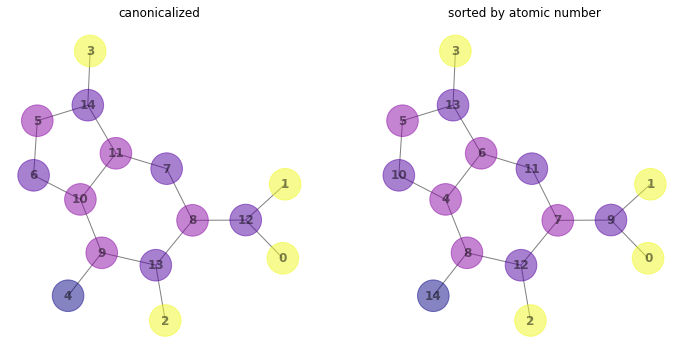

In [4]:
m_sorted_by_atomic_numbers = sort_molecule_by_atomic_numbers(m_canon)
print_molecule(m_sorted_by_atomic_numbers, "sorted by atomic number")
draw_molecules([m_canon, m_sorted_by_atomic_numbers], ["canonicalized", "sorted by atomic number"])

However, in a typical molecule there are multiple atoms with the same atomic number. Consider for example the five `N` atoms above. To further differentiate these `N` atoms, they have been ranked [lexicographically](https://en.wikipedia.org/wiki/Lexicographic_order) by the atomic numbers of their neighbours. More specifically, for each atom `a` we constructed a list of the atomic numbers of `a`'s neighbors, like so:

| index | list of neighboring atomic number (decreasing order) |
|-------|-----------------------------------|
| 9     | [6, 1, 1] |
| 10    | [6, 6] |
| 11    | [6, 6] |
| 12    | [6, 6, 1] |
| 13    | [6, 6, 1] |

Note that each list of neighboring atomic numbers is sorted in decreasing order. This ensures that the lexicographic sorting ranks atoms with identical atomic numbers by their "largest" neighbors (in terms of atomic numbers). At this point we can also see why it's important to canonicalize the molecule prior to sorting: the atoms with indices 10 and 11 cannot be sorted based on their neighbors' atomic numbers (likewise indices 12 and 13). Without canonicalization, these indices would pertain to different atoms depending on the inital configuration of the molecule (i.e., the way it's read from the molfile).

Finally, we can write the string representation for the molecule.

In [5]:
write_string_representation(m_sorted_by_atomic_numbers)

'C5H5N5O:(0, 9)(1, 9)(2, 12)(3, 13)(4, 6)(4, 8)(4, 10)(5, 10)(5, 13)(6, 11)(6, 13)(7, 9)(7, 11)(7, 12)(8, 12)(8, 14)'

# Invariance Test
In order to be useful for the identification of a molecule, the string representation must be invariant. That is, irrespective of a molecule's initial atom indices, the serialization should always result in the same string representation. Below we set up a simple test of invariance. For each molecule in our testset, we do the following. After loading the molecule, we randomly permute its atom indices, resulting in an original atom `m` and a permuted atom `m_permuted`. This is akin to obtaining the same molecule from two users who drew the atoms in different order, resulting in different atom indices. Subsequently, we assert that the string representations of `m` and `m_permuted` are identical. If this assertion fails, the serialization does not result in a unique string representation for `m`.

In [6]:
testfiles = list(Path(MOLFILEPATH).glob("*/*.mol"))
    
def load_molfile(path):
    m = MolFromMolFile(str(path), removeHs=False)
    try:
        # Unfortunately, RDKit exceptions cannot be caught. However, MolFromMolFile returns None if validation fails.
        n_atoms = m.GetNumAtoms() # raises AttributeError in case m_original is None
        if n_atoms < 1:
            raise Exception(f"Molecule has < 1 ({n_atoms}) atoms")
        return m
    except Exception as e:
        return None
 
def test_invariance(m):
    m_permuted = permute_molecule(m)

    m_canon = sort_molecule_by_canonical_indices(m)
    m_permuted_canon = sort_molecule_by_canonical_indices(m_permuted)
    
    m_sorted = sort_molecule_by_atomic_numbers(m_canon)
    m_permuted_sorted = sort_molecule_by_atomic_numbers(m_permuted_canon)
    
    string_original = write_string_representation(m_sorted)
    string_permuted = write_string_representation(m_permuted_sorted)
    
    try:
        assert string_original == string_permuted, f"{string_original}\ndoesn't match\n{string_permuted}."
        print(f"{string_original}\nmatches\n{string_permuted}.")
        return True
    except AssertionError as e:
        print(e)
        return False

n_failed_molecules = 0
n_molecules = 0
for molfile in testfiles:
    m = load_molfile(molfile)
    if not m: continue
    print(f"\nTesting {str(molfile)} for invariance...\n")
    if not test_invariance(m): n_failed_molecules += 1
    n_molecules += 1
        
print(f"\n{n_failed_molecules}/{n_molecules} invariance tests failed.")


Testing ../test/testfiles/2-8-dimethyldecane/2-8-dimethyldecane.mol for invariance...

C12H26:(0, 26)(1, 26)(2, 26)(3, 27)(4, 27)(5, 27)(6, 28)(7, 28)(8, 28)(9, 29)(10, 29)(11, 29)(12, 30)(13, 30)(14, 31)(15, 31)(16, 32)(17, 32)(18, 33)(19, 33)(20, 34)(21, 34)(22, 35)(23, 35)(24, 36)(25, 37)(26, 34)(27, 36)(28, 36)(29, 37)(30, 31)(30, 32)(31, 33)(32, 35)(33, 36)(34, 37)(35, 37)
matches
C12H26:(0, 26)(1, 26)(2, 26)(3, 27)(4, 27)(5, 27)(6, 28)(7, 28)(8, 28)(9, 29)(10, 29)(11, 29)(12, 30)(13, 30)(14, 31)(15, 31)(16, 32)(17, 32)(18, 33)(19, 33)(20, 34)(21, 34)(22, 35)(23, 35)(24, 36)(25, 37)(26, 34)(27, 36)(28, 36)(29, 37)(30, 31)(30, 32)(31, 33)(32, 35)(33, 36)(34, 37)(35, 37).

Testing ../test/testfiles/2-aminopyridine/2-aminopyridine.mol for invariance...

C5H6N2:(0, 9)(1, 6)(2, 7)(3, 8)(4, 11)(5, 11)(6, 8)(6, 9)(7, 8)(7, 10)(9, 12)(10, 11)(10, 12)
matches
C5H6N2:(0, 9)(1, 6)(2, 7)(3, 8)(4, 11)(5, 11)(6, 8)(6, 9)(7, 8)(7, 10)(9, 12)(10, 11)(10, 12).

Testing ../test/testfiles/acetylace

In [7]:
testfiles = list(Path(MOLFILEPATH).glob("*/*.mol"))
loaded = []
loaded_with_problems = []
failed = []
for molfile in testfiles:
    m = MolFromMolFile(str(molfile), removeHs=False, sanitize=False)
    if m:
      problems = DetectChemistryProblems(m)
      if problems:
        loaded_with_problems.append(str(molfile))
        for problem in problems:
          print(problem.Message())
      else:
        loaded.append(str(molfile))

      # m.UpdatePropertyCache(strict=False)
      # Chem.SanitizeMol(m,Chem.SanitizeFlags.SANITIZE_FINDRADICALS|Chem.SanitizeFlags.SANITIZE_KEKULIZE|Chem.SanitizeFlags.SANITIZE_SETAROMATICITY|Chem.SanitizeFlags.SANITIZE_SETCONJUGATION|Chem.SanitizeFlags.SANITIZE_SETHYBRIDIZATION|Chem.SanitizeFlags.SANITIZE_SYMMRINGS,catchErrors=True)
    else:
      failed.append(str(molfile))

print(loaded, len(loaded))
print(loaded_with_problems, len(loaded_with_problems))
print(failed, len(failed))

Explicit valence for atom # 2 N, 4, is greater than permitted
Explicit valence for atom # 4 N, 4, is greater than permitted
Explicit valence for atom # 0 C, 5, is greater than permitted
Explicit valence for atom # 1 C, 5, is greater than permitted
Explicit valence for atom # 2 C, 5, is greater than permitted
Explicit valence for atom # 3 C, 5, is greater than permitted
Explicit valence for atom # 4 C, 5, is greater than permitted
Explicit valence for atom # 5 C, 5, is greater than permitted
Explicit valence for atom # 0 C, 5, is greater than permitted
Explicit valence for atom # 1 C, 5, is greater than permitted
Explicit valence for atom # 2 C, 5, is greater than permitted
Explicit valence for atom # 3 C, 5, is greater than permitted
Explicit valence for atom # 0 B, 4, is greater than permitted
Explicit valence for atom # 1 H, 2, is greater than permitted
Explicit valence for atom # 2 B, 4, is greater than permitted
Explicit valence for atom # 3 H, 2, is greater than permitted
Explicit